# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Compare relu variants
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# # create a new column for binarized (boolean) quality
# data['boolQuality'] = 0
# # data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
# data['boolQuality'][data['quality']>5] = 1

# note: use the following lines to avoid the warning message
#tmp = (data['quality']>qualThreshold ).astype(int)
#data['boolQuality'] = tmp

In [3]:
def create_data_loaders(threshold=5):

    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>threshold] = 1

    # convert from pandas dataframe to tensor
    dataT  = torch.tensor( data[cols2zscore].values ).float()
    labels = torch.tensor( data['boolQuality'].values ).float()
    labels = labels[:,None] # transform to matrix

    # use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = torch.utils.data.TensorDataset(train_data,train_labels)
    test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

    # finally, translate into dataloader objects
    batchsize    = 64
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
    
    return train_loader, test_loader

In [28]:
# test the dataset and the number of samples

# note that the data are roughly balanced with thresh=5, not 4 or 6
train_loader,test_loader = create_data_loaders(6)

# get number of high/low quality wines
qualityRatings = train_loader.dataset.tensors[1].detach()
print('%s low-rated wines' %torch.sum(qualityRatings==0).item())
print('%s high-rated wines' %torch.sum(qualityRatings==1).item())

1246 low-rated wines
191 high-rated wines


C:\Users\pmiha\AppData\Local\Temp\ipykernel_10208\647749103.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>threshold] = 1
C:\Users\pmiha\AppData\Local\Temp\ipykernel_10208\647749103.py:4: SettingWithC

In [4]:
train_loader, test_loader = create_data_loaders(threshold=5)

C:\Users\pmiha\AppData\Local\Temp\ipykernel_10208\647749103.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>threshold] = 1
C:\Users\pmiha\AppData\Local\Temp\ipykernel_10208\647749103.py:4: SettingWithC

# Re-organize the data: train/test in DataLoaders

In [ ]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Now for the DL part

In [5]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun
  
  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

# Train the model

In [29]:
# a function that trains the model

# global parameter
numepochs = 500

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(), lr=.001, weight_decay=0.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [7]:
winenet = ANNwine('LeakyReLU')
trainAcc,testAcc,losses = trainTheModel()

In [8]:
X,y = next(iter(test_loader)) 
yHat = winenet(X)
itemAccuracy = ((yHat>0) == y).float()

perQualAcc = [ 100*torch.mean(itemAccuracy[y==0]) ,
            100*torch.mean(itemAccuracy[y==1]) ]

In [9]:
perQualAcc

[tensor(72.), tensor(85.8824)]

C:\Users\pmiha\AppData\Local\Temp\ipykernel_10208\647749103.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>threshold] = 1
C:\Users\pmiha\AppData\Local\Temp\ipykernel_10208\647749103.py:4: SettingWithC

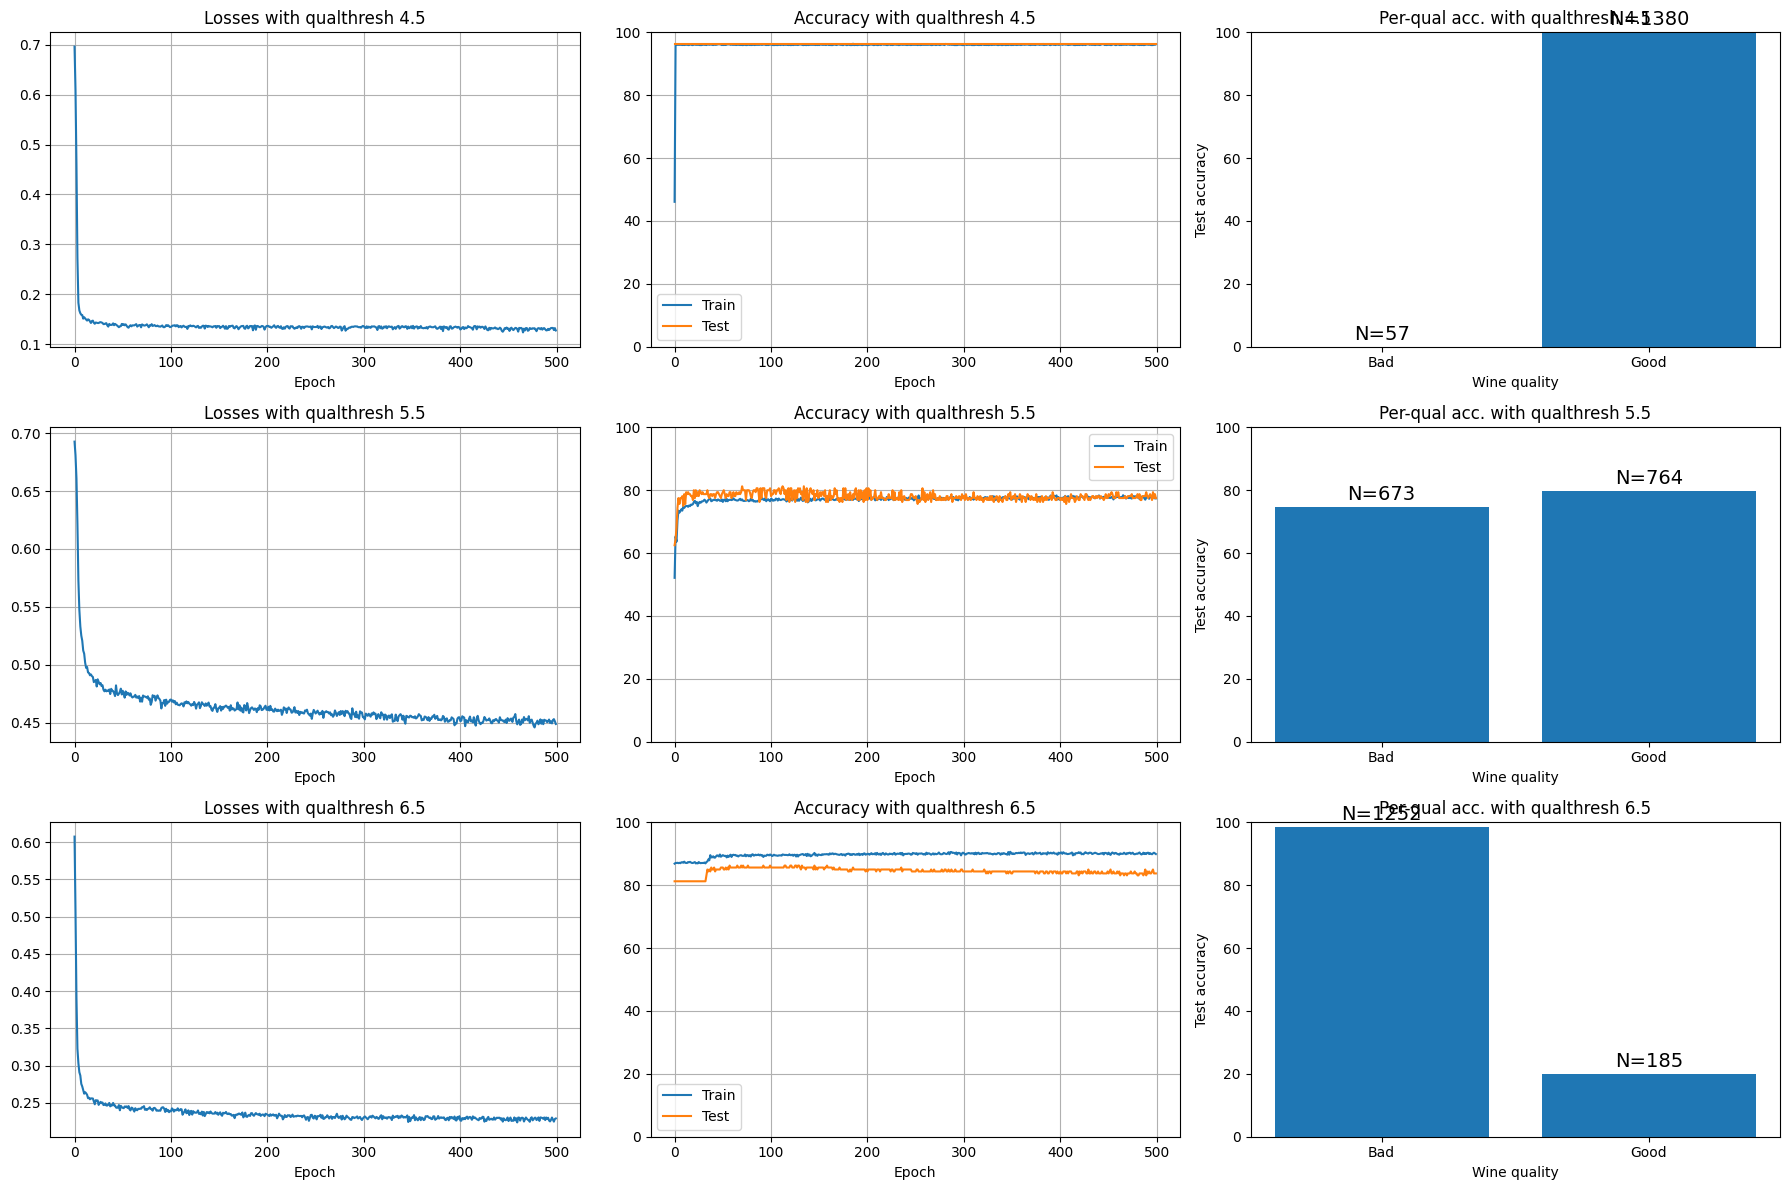

In [30]:
# note: this cell takes around 5 mins

# setup the figure
fig,ax = plt.subplots(3,3,figsize=(18,12))

# the quality thresholds
qualityThresholds = [4,5,6]


# loop over quality thresholds
for quali in range(len(qualityThresholds)):

  # create the data and model, and train it
  train_loader,test_loader = create_data_loaders( qualityThresholds[quali] )
  winenet = ANNwine('LeakyReLU')
  trainAcc,testAcc,losses = trainTheModel()

  # compute accuracy per quality type
  X,y = next(iter(test_loader))
  itemAccuracy = ((winenet(X)>0) == y).float()
  perQualAcc  = [ 100*torch.mean(itemAccuracy[y==0]) ,
                  100*torch.mean(itemAccuracy[y==1]) ]


  # plot losses
  ax[quali,0].plot(losses)
  ax[quali,0].set_title('Losses with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,0].set_xlabel('Epoch')
  ax[quali,0].grid()

  # plot overall accuracy
  ax[quali,1].plot(trainAcc,label='Train')
  ax[quali,1].plot(testAcc,label='Test')
  ax[quali,1].set_title('Accuracy with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,1].legend()
  ax[quali,1].set_xlabel('Epoch')
  ax[quali,1].set_ylim([0,100])
  ax[quali,1].grid()

  # plot the per-quality accuracy
  bh = ax[quali,2].bar(['Bad','Good'],perQualAcc)
  ax[quali,2].set_ylim([0,100])
  ax[quali,2].set_xlabel('Wine quality')
  ax[quali,2].set_ylabel('Test accuracy')
  ax[quali,2].set_title('Per-qual acc. with qualthresh ' + str(qualityThresholds[quali]+.5))

  # print the counts on top of each bar
  for i,r in enumerate(bh):
    N = torch.sum(train_loader.dataset.tensors[1]==i).item()
    ax[quali,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
              'N=%s'%N, ha='center', va='bottom', fontsize=14)


plt.tight_layout()
plt.show()

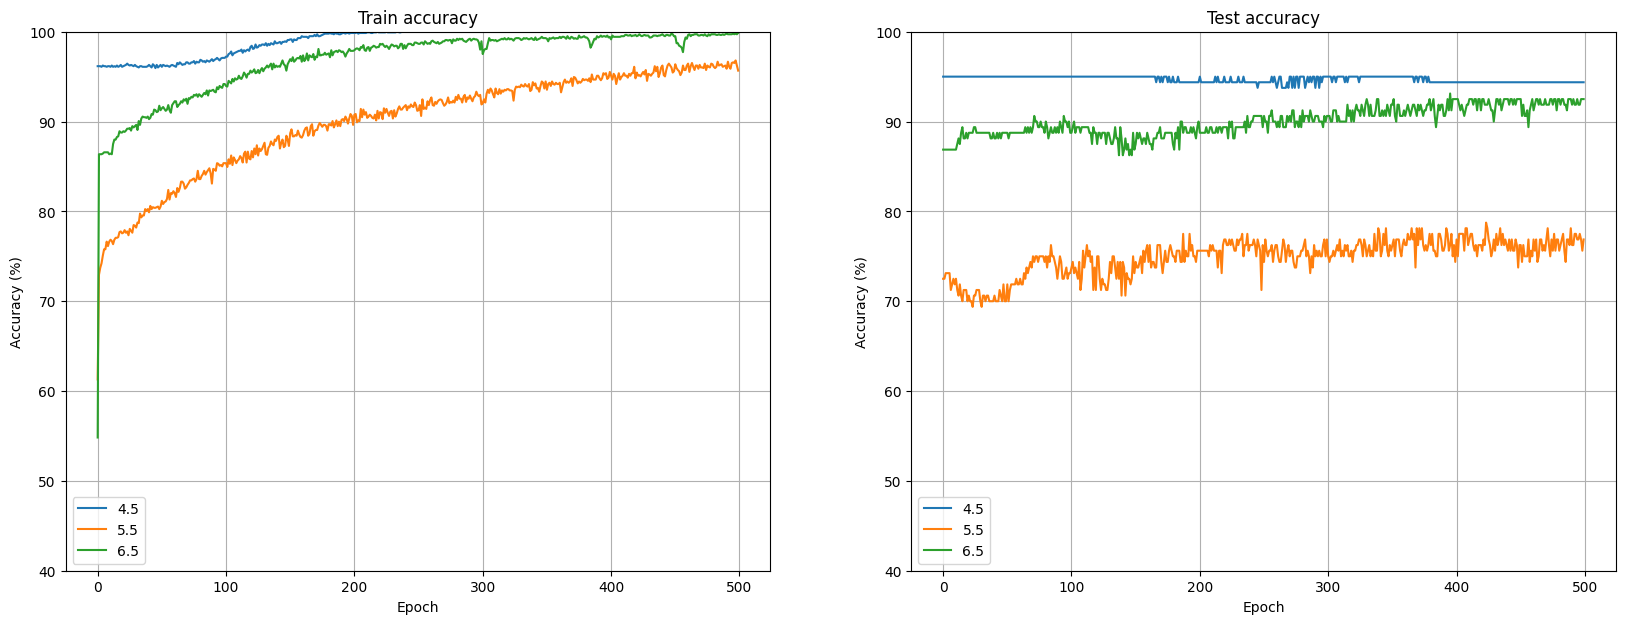

In [10]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(thresholds)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([40,100])
  ax[i].grid()

plt.show()

# Additional explorations

In [ ]:
# This was a pretty straightforward codeChallenge, so there isn't much to expand. Feel free to try exploring the 
# standard DL metaparameters, including learning rate, number of training epochs, and batch size.
# 
# It's also interesting the include other activation functions into the comparison. The following site lists the functions.
#   https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
